# Подготовка

In [1]:
!ls

__notebook__.ipynb


In [2]:
!git clone -b seminar_6 https://github.com/AlekseySpasenov/dl-course.git

Cloning into 'dl-course'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 210 (delta 31), reused 113 (delta 6), pack-reused 0
Receiving objects: 100% (210/210), 62.42 MiB | 20.51 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
%cd ./dl-course/2023_spring/lecture6

/kaggle/working/dl-course/2023_spring/lecture6


In [4]:
path = "https://downloader.disk.yandex.ru/disk/868739035ca6b94b8e905317b871814de608e122accfaaa1faa8d4101602a109/642cb558/_Es8VZKUcDX9pScl2Gn8MM7o0_eecLJSWO_uSeTBRXLNpNgyFu4rNgI6qAGLm4h2yP4KDprpkzHelRMRhJhbKg%3D%3D?uid=0&filename=seminar_objdet_retina_oi5_ball.zip&disposition=attachment&hash=/pQQe9cIZeBQzohR3kl0kTNBjUr%2BPRJmm8direLxFftchvert7vGYAaq9sRqB%2BlKq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=16238026&fsize=1074595497&hid=e84d8a05378d0a07a5498e7e0b640dc7&media_type=compressed&tknv=v2"
!wget '{path}' -O seminar_objdet_retina_oi5_ball.zip

--2023-04-04 22:25:56--  https://downloader.disk.yandex.ru/disk/868739035ca6b94b8e905317b871814de608e122accfaaa1faa8d4101602a109/642cb558/_Es8VZKUcDX9pScl2Gn8MM7o0_eecLJSWO_uSeTBRXLNpNgyFu4rNgI6qAGLm4h2yP4KDprpkzHelRMRhJhbKg%3D%3D?uid=0&filename=seminar_objdet_retina_oi5_ball.zip&disposition=attachment&hash=/pQQe9cIZeBQzohR3kl0kTNBjUr%2BPRJmm8direLxFftchvert7vGYAaq9sRqB%2BlKq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=16238026&fsize=1074595497&hid=e84d8a05378d0a07a5498e7e0b640dc7&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s742sas.storage.yandex.net/rdisk/868739035ca6b94b8e905317b871814de608e122accfaaa1faa8d4101602a109/642cb558/_Es8VZKUcDX9pScl2Gn8MM7o0_eecLJSWO_uSeTBRXLNpNgyFu4rNgI6qAGLm4h2yP4KDprpkzHelRMR

In [5]:
!unzip -q seminar_objdet_retina_oi5_ball.zip -d seminar_objdet_retina_oi5_ball

In [6]:
!ls

README.md	  retinanet			      workshop.ipynb
dataset.py	  seminar_objdet_retina_oi5_ball      workshop_completed.ipynb
images		  seminar_objdet_retina_oi5_ball.zip
requirements.txt  visualization.py


In [7]:
!pip install -r requirements.txt

  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373914 sha256=53c96cb7a9722f0d495e6e1b6347fb88be4ada23691f4ff041170971fb5d4284
  Stored in directory: /root/.cache/pip/wheels/d0/90/d4/e9ae0a3cdbd8e0cddf6b5fe8c31774fb9bd0ae4e9754fb2314
Successfully built pycocotools


In [8]:
import os
import sys
import cv2
import json
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)


from visualization import show_image, draw_predictions

Device is: cuda


Подгрузим тестовое изображение и сделаем из него батч размера 1. Это пригодится нам для демонстрации работы отдельных компонентов модели.

In [9]:
def make_tensor(image, device=None):
    tensor = to_tensor(image).unsqueeze(0)
    tensor = normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

In [10]:
%%capture
image_example = cv2.imread("images/zoo.jpg")


image_example = cv2.cvtColor(image_example, cv2.COLOR_BGR2RGB)
print("Image shape", image_example.shape)

tensor_example = make_tensor(image_example, device)
print("Tensor size", tensor_example.size())

show_image(image_example)

---

Поскольку модель имеет несколько отдельных модулей, реализуем их и положим в один композиционный класс:

- `RetinaNet`
  - `.backbone` - нейросеть для извлечения признаков; модифицированный `ResNet`, возвращающий карты активаций (вместо логитов);
  - `.fpn` - нейросеть для построения пирамиды признаков из выходов `.backbone`;
  - `.anchor_generator` - класс для построения наборов "якорных" боксов (anchors), на основе которых будет производится поиск объектов;
  - `.cls_head` - нейросеть для классификации каждого из anchor boxes;
  - `.reg_head` - нейросеть для регрессии уточняющих коэффициентов координат каждого из anchor boxes;
  - `.focal_loss` - реализация лосс-функции (да, ее можно поместить прямо в модель).

---

#### Backbone: Модифицированный ResNet

ResNet - семейство архитектур, у которого главная вычислительная единица - это т.н. residual-block:

![residuals](https://github.com/POTATOCHKA/temp_repo/blob/main/images/residual.png?raw=1)

Модели `ResNet-*` состоят из блоков, объединенных в четыре слоя (`layerX`); между слоями происходит 1) понижение размерности HW и 2) увеличение "ширины" блоков (число каналов в картах).

**NB: картинка ниже - для сети ResNet-34, в которой используются "простые" all-3x3 residual-блоки, как на картинке выше слева. В ResNet-50 используются `bottleneck`-блоки (соответственно сверху справа).
Число слоев у этих моделей одинаковое (а вот число блоков в слоях и их ширина отличаются).**

![resnet34](https://github.com/POTATOCHKA/temp_repo/blob/main/images/resnet34.png?raw=1)

Обычно (для задач типа классификации или регрессии) на выходе модели оказывается вектор (размера `C` = числу классов или 1 - для регрессии).
Но для задачи детектирования понадобятся промежуточные карты активаций, на основе который будет построена пирамида. 
На рисунке выше указаны карты `C3`, `C4` и `C5` - их и должен вернуть метод `.forward` нашей базовой сети.

**Задание**: реализовать метод `.forward()`, который должен возвращать карты активаций после слоев `layer2`, `layer3`, `layer4` в виде списка/кортежа.

In [11]:
from retinanet.utils import BasicBlock, Bottleneck  # See code

class ResNet(nn.Module):

    def __init__(self, num_classes, block, layers_sizes):
        """
        ResNet constructor.
        
        Args:
            - num_classes: int number of outputs for model.
            - block: class to use as residual block in model (BasicBlock or Bottleneck).
            - layers_sizes: list of sizes (number of blocks) for each of the 4 layers.
        """
        self.inplanes = 64
        super(ResNet, self).__init__()
        
        # Input convolution: larger (7x7) and with increased stride (2).
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Four layers with residual blocks. Each layer has similar structure
        self.layer1 = self._make_layer(block, 64, layers_sizes[0])
        self.layer2 = self._make_layer(block, 128, layers_sizes[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers_sizes[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers_sizes[3], stride=2)
        
    def _make_layer(self, block, planes, num_blocks, stride=1):
        """
        Method to create layer for ResNet using residual blocks.
        
        Args:
            - block: class to use as residual block in model (BasicBlock or Bottleneck).
            - planes: number of channels in layer's activation maps (also known as layer 'width').
            - num_blocks: number of blocks in layer.
            
        Returns:
            nn.Sequential object containing residual blocks.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, inputs):
        """
        Method for "__call__".
        
        Args:
            - inputs: batch of images shaped Bx3xHxW.
            
        Returns:
            List of feature maps tensors from layers 2, 3, 4.
        """
        
        # TODO: 
        # Write code to run all the model layers (do not forget to run input convolution/bn/activation/pooling) 
        # and to return feature maps from layer2, layer3, layer4.
        
        ### YOUR CODE HERE
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        ### END OF YOUR CODE
        
        return (x2, x3, x4)

In [12]:
num_classes = 80

print("ResNet50:")
resnet50_layers_sizes = [3, 4, 6, 3]      
resnet50 = ResNet(num_classes=num_classes, block=Bottleneck, layers_sizes=resnet50_layers_sizes).to(device)

print(resnet50)

ResNet50:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [13]:
print("Feature maps sizes from layer2-4 of ResNet50:")
feature_maps_example = resnet50(tensor_example)
for fm in feature_maps_example:
    print(fm.size())

Feature maps sizes from layer2-4 of ResNet50:
torch.Size([1, 512, 68, 100])
torch.Size([1, 1024, 34, 50])
torch.Size([1, 2048, 17, 25])


---

#### Feature Pyramid: собираем пирамиду активаций

Теперь перейдем к модулю, который сделает из последовательности карт активаций пирамиду.

Идея `Feature Pyramid` в том, чтобы, скомбинировав карты с разных слоев основной сети (`backbone`), получить карты одновременно "семантически богатые" и с большим рецептивным полем.

![fpn](https://github.com/POTATOCHKA/temp_repo/blob/main/images/fpn.png?raw=1)

На рисунке выше изображена пирамида из 3 уровней. Авторы [оригинальной статьи](https://arxiv.org/pdf/1708.02002.pdf) указывают (примечание на стр.4), что в их пирамиде 5 слоев, которые обозначаются от $P_3$ до $P_7$. При этом соответствие слоев пирамиды картам активации такое: $C_3 - P_3$, $C_4 - P_4$, $C_5 - P_5$, а два дополнительных слоя пирамиды $P_6$ и $P_7$ получаются последовательно свертками из $P_5$ (уже без сложения с низкоуровневыми картами)

Каждая из карт $C_i$ ($C_5$ - $C_3$):
1. Сворачивается с ядром 1х1, получается $C'_i$
2. Суммируется с выходной картой выше $C'_{i+1}$ (нет у $C_5$), увеличенной вдвое, и после свертки с ядром 3х3 отправляется на выход ($P_i$).

**Задание**: реализовать кусок метода `.forward()` для вычисления `P3` (по аналогии с `P5` & `P4`).

In [14]:
class PyramidFeatures(nn.Module):
    
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        """
        FPN constructor.
        
        Args:
            - C3_size: num features in C3 map.
            - C4_size: num features in C4 map.
            - C5_size: num features in C5 map.
            - feature_size: num features in output maps.
        """
        super(PyramidFeatures, self).__init__()

        # For P5
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # For P4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # For P3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)
        
        # For P6 
        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # For P7
        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        """
        Method for "__call__".
        
        Args:
            - inputs: List of C3, C4, C5 activation maps from backbone.
            
        Returns:
            List of pyramid feature maps from P3 to P7.
        """
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)
        
        # TODO: 
        # Write code to compute P3_x output map.
        # Almost like P4_x & P5_x, but no need for upsampling itself
        # (as we do not have 'lower' map P2)
        
        # YOUR CODE HERE
        P3_x = self.P3_1(C3)
        P3_x = P4_upsampled_x + P3_x
        P3_x = self.P3_2(P3_x)
        # END OF YOUR CODE
        
        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return (P3_x, P4_x, P5_x, P6_x, P7_x)

In [15]:
fpn_sizes = (512, 1024, 2048)  # ResNet50
fpn = PyramidFeatures(*fpn_sizes).to(device)

print("Feature pyramid sizes:")
features_pyramid_example = fpn(feature_maps_example)
for fp in features_pyramid_example:
    print(fp.size())

Feature pyramid sizes:
torch.Size([1, 256, 68, 100])
torch.Size([1, 256, 34, 50])
torch.Size([1, 256, 17, 25])
torch.Size([1, 256, 9, 13])
torch.Size([1, 256, 5, 7])


Обратим внимание:
* У первого слоя (который мы называем $P_3$) линейные размеры в 8 = $2^3$ раз меньше, чем у оригинального изображения.
* На каждом слое пирамиды линейные размеры уменьшаются вдвое.

То есть размеры слоя $P_i$ меньше размеров исходного изображения в $2^i$ раз.

---

На данный момент у нас есть инструменты для извлечения карт признаков из изображения. 

Теперь, если бы мы работали в парадигме, например, `Fast R-CNN` (не надо так), мы бы запустили на этих признаках алгоритм `SelectiveSearch`, получили координаты предполагаемых локаций с объектами (в виде обрамляющих прямоугольников), "вырезали" их проекции из каждого слоя пирамиды признаков и подали в подсети для определения классов и регрессии относительных координат.

Но, поскольку мы работаем в парадигме single-shot-детектирования, мы сделаем все за один проход. 
С каждым супер-пикселем любого из слоев пирамиды (супер-пиксель - это одна точка (x, y) на карте признаков) мы ассоциируем некоторую область на исходном изображении, и для каждой такой области назначим набор т.н. `proposals`, то есть предполагаемых обрамляющих прямоугольников, лежащих в этой области.

![subnet2](https://github.com/POTATOCHKA/temp_repo/blob/main/images/subnet_receptive_2.jpeg?raw=1) ![subnet](https://github.com/POTATOCHKA/temp_repo/blob/main/images/subnet_receptive.jpeg?raw=1)


Эти наборы нужны для того, чтобы связать суперпиксели активационных карт с ground-truth объектами при обучении. 

---

#### Anchors generator

В качестве основы для набора `proposals` возьмем три прямоугольника: "горизонтальный" (соотношение сторон H:W = 1:2, в коде - `ratio`), "квадрат" (H:W = 1:2) и "вертикальный" (H:W = 2:1).

Если кроме 3 вариантов соотношения сторон взять 3 варианта для масштаба, получим набор из 9 прямоугольников. 

![1](https://github.com/POTATOCHKA/temp_repo/blob/main/images/proposals.png?raw=1)


После того, как зафиксирован набор `proposals` для одного супер-пикселя, нужно отобразить все прямоугольники (для всех супер-пикселей на всех уровнях пирамиды) на исходное изображение, чтобы связать их с ground-truth прямоугольниками объектов.

Класс `AnchorsGenerator` нужен затем, чтобы сгенерировать наборы `proposals` для всех слоев, раскидать их по сетке и спроецировать на исходное изображение.

**NB: Конкретные положения прямоугольников зависят как от гипер-параметров генератора, так и от размеров изображения!**

In [16]:
from retinanet.anchors import generate_anchors, shift 


class AnchorsGenerator(nn.Module):
    
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None, device=None):
        """
        AnchorGenerator constructor.
        
        Args:
            - pyramid_levels: list of log_2(image_width / pyramid_level_width) for every pyramid level.
            - strides: list of step sizes for sliding each anchor box set for every pyramid level.
            - sizes: list of basic sizes for anchor boxes for every pyramid level.
            - ratios: list of anchor boxes aspect ratio sets for every pyramid level.
            - scales: list of anchor boxes scale sets for every pyramid level.
            - device: device to move results to.
        """
        super(AnchorsGenerator, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

        if device is None:
            device = torch.cuda.is_available() and 'cuda' or 'cpu'
        self.device = device

    def forward(self, image, verbose=False):
        """
        Method for "__call__".
        
        Args:
            - image: tensor of shape B x C x H x W.
            
        Returns:
            tensor of computed anchor box coordinatates, size total_num_anchors x 4.
        """
        image_shape = image.shape[2:]  # h, w
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # Compute anchors over all pyramid levels
        
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            
            # Generate 9 anchors
            anchors = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            
            # Grid all over the shape with stride
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            
            if verbose:
                print(f"{idx}\tpyr_level = {p}\tstride = {self.strides[idx]:3d}\tsize={self.sizes[idx]:3d}\tanchors shape = {shifted_anchors.shape}")
            
            all_anchors = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(self.device)

In [17]:
anchors_generator = AnchorsGenerator(device=device)

anchors_example = anchors_generator(tensor_example, verbose=True)[0].cpu()
print()
print(anchors_example.size())

0	pyr_level = 3	stride =   8	size= 32	anchors shape = (61200, 4)
1	pyr_level = 4	stride =  16	size= 64	anchors shape = (15300, 4)
2	pyr_level = 5	stride =  32	size=128	anchors shape = (3825, 4)
3	pyr_level = 6	stride =  64	size=256	anchors shape = (1053, 4)
4	pyr_level = 7	stride = 128	size=512	anchors shape = (315, 4)

torch.Size([81693, 4])


Получили общее число `proposals`, каждый из которых задается четырьмя числами - x1, y1, x2, y2.

Отрисуем по несколько полученных прямоугольников с каждого слоя на исходном изображении.

In [18]:
%%capture
anchors_num_per_level = [61200, 15300, 3825, 1053, 315]
anchors_per_level = np.split(anchors_example, np.cumsum(anchors_num_per_level)[:-1])

num_to_show = 32
for anchor_boxes_level in anchors_per_level:
    image_example_with_anchors = image_example.copy()
    for i in np.random.choice(len(anchor_boxes_level), size=num_to_show):
        anchor_box = anchor_boxes_level[i]
        x1, y1, x2, y2 = anchor_box.numpy().astype(np.int32)
        cv2.rectangle(image_example_with_anchors, (x1, y1), (x2, y2), np.random.randint(255, size=3).tolist(), 2)
    
    show_image(image_example_with_anchors)

Теперь, когда у нас есть модуль для генерации якорных прямоугольников, можем перейти к сеткам для классификации и регрессии на их основе.

---

#### Regression & Classification subnets

Классификацию (объект одного из классов или фон) и регрессию (уточнение координат объекта относительно `anchor box`) будет делать в сверточной манере.

![overall](https://github.com/POTATOCHKA/temp_repo/blob/main/images/overall.png?raw=1)

* Регрессия

Поскольку с каждым супер-пикселем у нас ассоциировано 9 разных `proposals`, каждый из которых задан с помощью 4 чисел, то для регрессии нам потребуется 9 x 4 = 36 чисел в каждом суперпикселе. Значит, сделаем полносверточную сеть, которая не меняет размера карт активаций (то есть нет `pooling`-слоев и `stride`=1) и имеет на выходе 36 каналов. Таким образом, в каждом из `HxW` суперпикселей выходной карты будут храниться все необходимые таргеты.

**Задание:** напишите код для преобразования тензора с результатами из вида `B x (num_anchors * 4) x H x W` к виду `B x total_num_anchors x 4`.

In [19]:
class RegressionModel(nn.Module):
    
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        """
        RegressionModel consctructor. 
        
        RegressionModel is a fully-convolutional neural network that takes single feature pyramid level and
        outputs tensor of size total_number_of_anchors x 4.
        
        Args:
            - num_features_in: number of channels in every feature pyramid level.
            - num_anchors: size of anchor boxes set.
            - feature_size: size of internal activation maps.
        """
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        """
        Run regression on single feature pyramid level.
        
        Args:
            - x: feature pyramid level of shape B x num_features_in x H x W.
            
        Returns:
            tensor of size B x (H * W * num_anchors) x 4.
        """
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        # out is B x C x H x W, with C = 4 * num_anchors
        
        # TODO: change shape of `out` tensor to be `B x total_num_anchors x 4`.
        
        # YOUR CODE HERE
        out = out.permute(0, 2, 3, 1).reshape(len(out), -1, 4)

        # END OF YOUR CODE
        
        return out

In [20]:
num_features_in = 256
regression_head = RegressionModel(num_features_in).to(device)

regression_predictions = []
for features in features_pyramid_example:
    regression_predictions_at_level = regression_head(features)
    regression_predictions.append(regression_predictions_at_level)
    print(f"input: {features.size()}\t output: {regression_predictions_at_level.size()}")
regression_predictions = torch.cat(regression_predictions, dim=1) # batch x anchors x 4 [4 for bbox]

input: torch.Size([1, 256, 68, 100])	 output: torch.Size([1, 61200, 4])
input: torch.Size([1, 256, 34, 50])	 output: torch.Size([1, 15300, 4])
input: torch.Size([1, 256, 17, 25])	 output: torch.Size([1, 3825, 4])
input: torch.Size([1, 256, 9, 13])	 output: torch.Size([1, 1053, 4])
input: torch.Size([1, 256, 5, 7])	 output: torch.Size([1, 315, 4])


* Классификация

Архитектурно голова классификации идентична голове регрессии, отличие только в размере выхода (и активации): модель возвращает столько значений для каждого бокса, сколько классов в датасете, причем с активацией `Sigmoid`.

In [21]:
class ClassificationModel(nn.Module):
    
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        """
        ClassificationModel consctructor. 
        
        ClassificationModel is a fully-convolutional neural network that takes single feature pyramid level and
        outputs tensor of size total_number_of_anchors x num_classes.
        
        Args:
            - num_features_in: number of channels in every feature pyramid level.
            - num_anchors: size of anchor boxes set.
            - num_classes: number of classes in dataset (do not count the `background` class!).
            - prior: float number to use in weights initializatin.
            - feature_size: size of internal activation maps.
        """
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):        
        """
        Run classification on single feature pyramid level.
        
        Args:
            - x: feature pyramid level of shape B x num_features_in x H x W.
            
        Returns:
            tensor of size B x (H * W * num_anchors) x num_classes.
        """
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)
        # out is B x C x W x H, with C = num_classes * num_anchors
        
        out1 = out.permute(0, 2, 3, 1)
        batch_size, width, height, channels = out1.shape
        out2 = out1.reshape(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.reshape(x.shape[0], -1, self.num_classes)

In [22]:
classification_head = ClassificationModel(num_features_in, num_classes=num_classes).to(device)
classification_results = []

for feature in features_pyramid_example:
    classification_results_at_level = classification_head(feature)
    classification_results.append(classification_results_at_level)
    print(f"input: {feature.size()}\t output: {classification_results_at_level.size()}")
classification_results = torch.cat(classification_results, dim=1) # batch x anchors x classes

input: torch.Size([1, 256, 68, 100])	 output: torch.Size([1, 61200, 80])
input: torch.Size([1, 256, 34, 50])	 output: torch.Size([1, 15300, 80])
input: torch.Size([1, 256, 17, 25])	 output: torch.Size([1, 3825, 80])
input: torch.Size([1, 256, 9, 13])	 output: torch.Size([1, 1053, 80])
input: torch.Size([1, 256, 5, 7])	 output: torch.Size([1, 315, 80])


Теперь мы можем объединить все в одну композицию, класс `RetinaNet`.

---

#### RetinaNet

In [23]:
from retinanet.utils import BBoxTransform, ClipBoxes
from retinanet.losses import FocalLoss
from torchvision.ops import nms

Из интересного: метод `.forward()` работает по разному во время обучения и во время инференса:
- Во время обучения (`self.training = True`) функция возвращает список из двух лоссов - регрессионного и классификационного.
- Во время инференса функция возвращает предсказания: скоры, индексы классов и координаты боксов. 

Как было сказано ранне основной фичей RetinaNet является Focal loss ([paper](https://arxiv.org/pdf/1708.02002.pdf)):

$$\text{FL}(p_t) = -(1-p_t)^\gamma \log p_t$$

где $p_t = \text{sigmoid}(x)$ для позитивного класса и $p_t = 1- \text{sigmoid}(x) = \text{sigmoid}(-x)$ для негативного. 

Также помимо уже разобранных модулей будут использоваться:
- `BBoxTransform`: класс для сборки боксов из предсказаний регрессионной головы и набора якорных боксов.
- `ClipBoxes`: класс для усечения координат боксов при выходе за границы изображения.
- `FocalLoss`: класс для вычисления сложной функции потерь (на самом деле, в нем вычисляются оба лосса - для классификации и для регрессии).
  Внутри него происходит, например, ассоциация GT-боксов с якорными боксами.

In [24]:
class RetinaNet(nn.Module):
    
    def __init__(self, num_classes, backbone="resnet50", fpn_feature_size=256, subnets_feature_size=256, device=None):
        super(RetinaNet, self).__init__()
        
        self.device = device
        if backbone == "resnet50":
            self.backbone = ResNet(num_classes=num_classes, block=Bottleneck, layers_sizes=(3, 4, 6, 3)).to(device)
            self.fpn = PyramidFeatures(512, 1024, 2048, fpn_feature_size).to(device)
            
        else:
            raise NotImplementedError(backbone)
            
        self.regression_head = RegressionModel(num_features_in=fpn_feature_size, feature_size=subnets_feature_size).to(device)
        self.classification_head = ClassificationModel(num_features_in=fpn_feature_size, num_classes=num_classes, feature_size=subnets_feature_size).to(self.device)
        self._init_weights()
        
        self.anchors_generator = AnchorsGenerator(device=device)
        self.transform_bboxes = BBoxTransform(device=device)
        self.clip_bboxes = ClipBoxes()
        self.loss_fn = FocalLoss(device=device)
        

    def forward(self, inputs):
        """
        Apply RetinaNet pipeline to inputs.
        
        Args:
            - inputs: Either (images_batch, annotations) in training mode or images_batch otherwise. 
            images_batch is of shape (B x C x H x W), annotations of shape (B x N x 5) where N is a number of 
            GT boxes and 5 = 4 coords + 1 class label.
        
        Returns:
            Either (classification_loss, regression_loss) in training mode or (scores, nms_class, boxes) otherwise.
        """
        
        if self.training:
            images_batch, annotations = inputs
        else:
            images_batch = inputs
        
        features = self.backbone(images_batch.to(device))
        features_pyramid = self.fpn(features)
        classification_results = torch.cat([self.classification_head(f) for f in features_pyramid], dim=1)
        regression_results = torch.cat([self.regression_head(f) for f in features_pyramid], dim=1)
        
        anchors = self.anchors_generator(images_batch)
        
        if self.training:
            return self.loss_fn(classification_results, regression_results, anchors, annotations)
        
        transformed_anchors = self.transform_bboxes(anchors, regression_results)
        transformed_anchors = self.clip_bboxes(transformed_anchors, images_batch)

        scores = torch.max(classification_results, dim=2, keepdim=True)[0]
        scores_over_thresh = (scores > 0.3)[0, :, 0]

        if scores_over_thresh.sum() == 0:
            # no boxes to NMS, just return
            return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]

        # NMS iteratively removes lower scoring boxes which have an
        # IoU greater than iou_threshold with another (higher scoring) box
        classification_results = classification_results[:, scores_over_thresh, :]
        transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
        scores = scores[:, scores_over_thresh, :]

        anchors_nms_idx = nms(transformed_anchors[0,:,:], scores[0,:,0], 0.5)

        nms_scores, nms_class = classification_results[0, anchors_nms_idx, :].max(dim=1)

        return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]
    
    def _init_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classification_head.output.weight.data.fill_(0)
        self.classification_head.output.bias.data.fill_(-np.log((1.0 - prior) / prior))

        self.regression_head.output.weight.data.fill_(0)
        self.regression_head.output.bias.data.fill_(0)

Подгрузим веса из оригинального репозитория (модифицированные для нашего класса) и сделаем пробный прогон на тестовом изображении. Веса получены обучением модели на датасете COCO.

In [25]:
retinanet = RetinaNet(num_classes=80, device=device)
retinanet.eval();

In [26]:
with open("./seminar_objdet_retina_oi5_ball/FIXED_coco_resnet_50_map_0_335_state_dict.pt", "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
retinanet.load_state_dict(state_dict)

<All keys matched successfully>

Взглянем на результат работы модели на тестовом примере:

In [27]:
def run_and_show(model, image_or_tensor, threshold, class_to_label_map, verbose=False):
    if isinstance(image_or_tensor, np.ndarray):
        tensor = make_tensor(image_or_tensor)
        image = image_or_tensor
    elif isinstance(image_or_tensor, torch.Tensor):
        image = (image_or_tensor.numpy()[0] * 0.25) + 0.5
        tensor = image_or_tensor.permute(0, 3, 1, 2)
    else:
        raise NotImplementedError(type(image_or_tensor))
        
    with torch.no_grad():
        nms_scores, nms_classes, bboxes = model(tensor)
    
    nms_scores = nms_scores.cpu()
    nms_classes = nms_classes.cpu()
    bboxes = bboxes.cpu()
    
    if verbose:
        print(nms_scores.size(), nms_scores[:8])
        print(nms_classes.size(), nms_classes[:8])
        print(bboxes.size(), bboxes[:8])
        
    image_with_predictions = draw_predictions(image, bboxes, nms_scores, nms_classes, class_to_label_map, threshold=threshold)
    show_image(image_with_predictions)

In [28]:
with open("./seminar_objdet_retina_oi5_ball/coco_id_to_name.json", "rt") as fp:
    coco_class_to_label_map = json.load(fp)
coco_class_to_label_map = {int(k) - 1: v for k, v in coco_class_to_label_map.items()}

In [29]:
%%capture
run_and_show(retinanet, image_example, 0.5, coco_class_to_label_map, verbose=True)

---

#### 3. Дообучение RetinaNet

Наконец, убедимся в том, что наша модель может обучаться. 

У нас есть кусок датасета [OpenImages](https://storage.googleapis.com/openimages/web/index.html), которая содержит примеры класса `Ball`.
Будем обучать нашу модель детектировать 1 класс - мячи, шары и т.д.


Подгрузка данных:

In [30]:
%reload_ext autoreload

import tqdm

from torchvision import transforms
from torch.utils.data import DataLoader

from dataset import DetectionDataset

from retinanet.dataloader import Normalizer, Resizer, Augmenter, collater, AspectRatioBasedSampler, UnNormalizer

#### Аугментации

В задачах компьютерного зрения от набора обучающих данных зависит качество работы сети. Данных требуется много и хочется, чтобы они были наиболее разнородными. Собирать новые данные дорого и долго, поэтому часто используют аугментацию изображений.

Аугментация — создание новых данных на основе какого-то базиса. Можно взять несколько шаблонов / «идеальных» примеров (те данные, которые есть) и с помощью различных искажений расширить набор изображений. 
Можно использовать следующие искажения:
* Геометрические (афинные, проективные, ...).
* Яркостные/цветовые.
* Замена фона.
* Искажения, характерные для решаемой задачи: блики, шумы, размытие и т. д.

Популярные библиотеки для аугментации изображений:
* https://pytorch.org/vision/stable/transforms.html
* https://albumentations.ai

![overall](https://github.com/POTATOCHKA/temp_repo/blob/main/images/examples_grid.jpg?raw=1)

In [31]:
%%capture
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

example_transforms = transforms.Compose([
    Normalizer(), Resizer()
])
example_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", 
                                 transforms=example_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
iterator = iter(example_dataset)
exp_img = next(iterator)['img']
inv_tensor = inv_normalize(exp_img.permute(2,1,0))
show_image(inv_tensor.permute(2,1,0).numpy())

In [32]:
%%capture
class RandomGrayscale:

    def __init__(self, p = 1):
        self.proba = p
        self.to_gray = transforms.RandomGrayscale(p=self.proba)

    def __call__(self, sample):

        image, annots = sample['img'], sample['annot']
        image = self.to_gray(image.permute(2,1,0))
        return {'img':image, 'annot': annots}

example_transforms = transforms.Compose([
    Normalizer(), Resizer(), RandomGrayscale()
])
example_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", 
                                 transforms=example_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
iterator = iter(example_dataset)
exp_img = next(iterator)['img']
inv_tensor = inv_normalize(exp_img)
show_image(inv_tensor.permute(2,1,0).numpy())

In [33]:
train_transforms = transforms.Compose([
    Normalizer(), Augmenter(), Resizer()
])

val_transforms = transforms.Compose([
    Normalizer(), Resizer()
])

Теперь к созданию датасетов и даталоадеров.

Обратите внимание на `AspectRatioBasedSampler`: 
* Для обучения моделей в `pytorch` необходимо, чтобы все элементы в батче были одного размера.
* Поскольку мы учим полносверточную архитектуру на полных изображениях (а не на кропах, как в классификации), то нам нужно отресайзить их к одному размеру. 
Если у изображений разное соотношение сторон, мы будем добавлять рамки (padding).
* `AspectRatioBasedSampler` группирует изображения в датасете таким образом, чтобы в батч попадали изображения с как можно более похожим соотношением сторон, чтобы не делать слишком большие паддинги.

Датасеты устроены так, чтобы возвращать тензор изображения и тензор аннотаций к нему.

In [34]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json", 
                                 transforms=train_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
train_sampler = AspectRatioBasedSampler(train_dataset, batch_size=4, drop_last=False) # deepdive
train_dataloader = DataLoader(train_dataset, num_workers=8, collate_fn=collater, batch_sampler=train_sampler)

val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json", 
                               transforms=val_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
val_sampler = AspectRatioBasedSampler(val_dataset, batch_size=4, drop_last=False)
val_dataloader = DataLoader(val_dataset, num_workers=8, collate_fn=collater, batch_sampler=val_sampler)

In [35]:
item = train_dataset[0]
print(item["img"].size())    # H x W x 3
print(item["annot"].size())  # N x 5; 4 coords + 1 label.

torch.Size([640, 992, 3])
torch.Size([6, 5])


Теперь непосредственно к модели.

Во-первых, нужно заменить головы для классификации и регрессии для дообучения.
При этом у классификационной головы нужно указать число классов - 1.

In [36]:
retinanet.classification_head = ClassificationModel(num_features_in, num_classes=1)
retinanet.regression_head = RegressionModel(num_features_in)
retinanet.to(device);

Во-вторых, потребуется функция для переключения модулей нашей сети в режим обучения; сделаем так, чтобы можно было учить отдельные модули.

**Вопрос**: зачем "замораживать" BN?

In [37]:
def set_to_training(model, backbone=False, fpn=False, regression_head=True, classification_head=True, freeze_bn=False):
    model.train()
    model.requires_grad_(True)
    
    if not backbone:
        model.backbone.eval()
        model.backbone.requires_grad_(False)
    
    elif freeze_bn:
        for layer in model.backbone.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()
    
    if not fpn:
        model.fpn.eval()
        model.fpn.requires_grad_(False)
    
    if not regression_head:
        model.regression_head.eval()
        model.regression_head.requires_grad_(False)

    if not classification_head:
        model.classification_head.eval()
        model.classification_head.requires_grad_(False)

И простая функция для обучения на 1 эпохе.

In [38]:
import numpy as np
from mean_average_precision import MetricBuilder
import gc

In [39]:
def val_step(model, dataloader):
    model.eval()
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=1)
    for iter_num, data in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
      for img, gt in zip(data['img'], data['annot']):
        with torch.no_grad():
          nms_scores, nms_classes, bboxes = model(img.unsqueeze(0))
        preds = torch.cat([bboxes, nms_classes.unsqueeze(0).T, nms_scores.unsqueeze(0).T], dim = 1).cpu().detach().numpy()
        zeros = torch.zeros((gt.shape[0], 1))
        gt = torch.cat([gt, zeros, zeros], 1).cpu().detach().numpy()
        metric_fn.add(preds, gt)

        del img, gt, preds, zeros, nms_scores, nms_classes, bboxes
      gc.collect()
      torch.cuda.empty_cache()
    print(f"validation mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

    
def routine(retina_model, scheduler, train_loader, val_loader):
    epoch_loss = []
    torch.cuda.empty_cache()
    for iter_num, data in tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        optimizer.zero_grad()
        
        classification_loss, regression_loss = retina_model([data['img'].to(device).float(), data['annot'].to(device)])
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(retina_model.parameters(), 0.1)
        optimizer.step()

        epoch_loss.append(float(loss.item()))
        del data

    gc.collect()
    torch.cuda.empty_cache()
        
    print('Epoch: {} | Iteration: {} | Train classification loss: {:1.5f} | train regression loss: {:1.5f} | Epoch loss: {:1.5f}'\
          .format(epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))
    scheduler.step(np.mean(epoch_loss)) # should be val loss

Сначала обучим только новые головы в течение 1 эпохи:

In [40]:
set_to_training(retinanet, backbone=False, fpn=False, regression_head=True, classification_head=True, freeze_bn=True)

In [41]:
params = [p for p in retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [42]:
# epochs = 1
# for epoch_num in range(epochs):
#     routine(retinanet, scheduler, train_dataloader, val_dataloader)

In [43]:
# val_step(retinanet, val_dataloader)

И потом обучим всю сеть (с "замороженными" BN) - уже подольше.

In [44]:
set_to_training(retinanet, backbone=True, fpn=True, regression_head=True, classification_head=True, freeze_bn=False)

In [45]:
params = [p for p in retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [46]:
# epochs = 4
# for epoch_num in range(epochs):
#     routine(retinanet, scheduler, train_dataloader, val_dataloader)
    
#     if epoch_num % 10 == 0 or epoch_num + 1 == epochs:
#         torch.save(retinanet.state_dict(), f"dev_balls_retinanet_{epoch_num}.pt")        

In [47]:
# val_step(retinanet, val_dataloader)

Для иллюстрации результатов выберем случайные изображения из выборки и отрисуем предсказания.

In [48]:
with open("./seminar_objdet_retina_oi5_ball/oi5_ball_retinanet_ep=10.pt", "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
retinanet.load_state_dict(state_dict)

<All keys matched successfully>

In [49]:
retinanet.eval();

In [50]:
val_step(retinanet, val_dataloader)

100%|██████████| 57/57 [00:53<00:00,  1.06it/s]

validation mAP in all points: 0.41292092204093933


In [51]:
%%capture
for i in range(10):
    index = np.random.randint(len(train_dataset))
    tensor = train_dataset[index]["img"].unsqueeze(0)
    run_and_show(retinanet, tensor, 0.5, {0: "ball"}, verbose=True)

Пример из валидации:

In [52]:
%%capture
for i in range(10):
    index = np.random.randint(len(val_dataset))
    tensor = val_dataset[index]["img"].unsqueeze(0)
    run_and_show(retinanet, tensor, 0.5, {0: "ball"}, verbose=True)

### Резюме

Если бы мы учили детектор для какой-то конкретной задачи, то:

1. Учились бы на нескольких `GPU` (для адекватного размера батча)
2. Более аккуратно подбирали якорные боксы
3. По возможности использовали библиотечные модели (а не кустарные)

### Домшниее задание

Решить задачу детекции мячей с помощью другой модели
1. потребуется загрузить предобученную модель: https://pytorch.org/vision/stable/models.html , https://paperswithcode.com/sota/object-detection-on-coco
2. Создать класс датасета и даталоадера
3. Добавить аугментаций
4. Дообучить несколько эпох и посмотреть на качество

In [53]:
%%capture
!pip install boto3

In [54]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
import pandas as pd
from tqdm import tqdm
import PIL
import torchvision.utils as vutils
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights
import albumentations as A
import cv2

In [55]:
%cd /kaggle/working/

/kaggle/working


In [56]:
%%capture
!wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
!wget https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels-boxable.csv
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
!wget https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions-boxable.csv

In [57]:
df = pd.read_csv('validation-annotations-bbox.csv')
# data = df[data.Confidence==1]
gc.collect()
df['y'] = df.LabelName=='/m/018xm'
# mask = [(i<1000 or df.iloc[i].y==True) for i in range(df.shape[0])]
mask = [(df.iloc[i].y==True) for i in range(df.shape[0])]
df = df[mask]
gc.collect()
df.reset_index(drop=True)
df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,y
427,0052ea56ee869426,xclick,/m/018xm,1,0.000000,0.337500,0.033333,0.835417,0,1,0,0,0,True
428,0052ea56ee869426,xclick,/m/018xm,1,0.526563,0.848437,0.229167,0.658333,0,0,0,0,0,True
2542,01eeeccf29b85fa0,xclick,/m/018xm,1,0.343750,0.951562,0.079167,0.881250,0,0,0,0,0,True
2949,022caa5e84da4026,xclick,/m/018xm,1,0.345029,0.387427,0.162946,0.223214,1,0,0,0,0,True
3194,02760ace01bd113f,xclick,/m/018xm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298384,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.228125,0.301563,0.116667,0.218750,0,0,0,0,0,True
298385,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.485938,0.515625,0.152083,0.193750,0,0,0,0,0,True
298386,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.768750,0.934375,0.260417,0.477083,0,0,0,0,0,True
300379,fd1150844d3a7732,xclick,/m/018xm,1,0.408555,0.532448,0.561947,0.745575,1,0,0,0,0,True


In [58]:
df.y.sum()

343

In [59]:
with open('filter.txt', 'w') as f:
    for id in tqdm(df.ImageID):
        f.write(f"validation/{id}\n")

100%|██████████| 343/343 [00:00<00:00, 261572.05it/s]


In [60]:
!python downloader.py filter.txt --download_folder=OpenImages --num_processes=2

In [61]:
# weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
# model = ssdlite320_mobilenet_v3_large(weights=weights,
#                                       trainable_backbone_layers=4
#                                       )
weights = FCOS_ResNet50_FPN_Weights.COCO_V1
model = fcos_resnet50_fpn(weights=weights, trainable_backbone_layers=1)

Downloading: "https://download.pytorch.org/models/fcos_resnet50_fpn_coco-99b0c9b7.pth" to /root/.cache/torch/hub/checkpoints/fcos_resnet50_fpn_coco-99b0c9b7.pth


  0%|          | 0.00/124M [00:00<?, ?B/s]

In [62]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, labels, alb_transform=None, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        
        self.alb_transform = alb_transform
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels.iloc[idx].ImageID + '.jpg')
#         print(img_path)
        image = PIL.Image.open(img_path).convert('RGB')
        label = np.array(self.labels[self.labels.ImageID==self.labels.iloc[idx].ImageID])[:, [4,5,6,7,13]]
        # label[1]-=label[0]; label[3]-=label[2]
        label = label[:, [0,2,1,3,4]]
        label[:, 4] = 1 - label[:, 4]
        label[:, 0]*=image.size[0]; label[:, 1]*=image.size[1]
        label[:, 2]*=image.size[0]; label[:, 3]*=image.size[1]
        label = label.astype(float)
#         print(image.shape)
        # print(self.labels.iloc[idx])
              
        image = np.asarray(image)
        label = label.reshape((label.shape[0],-1))
        if self.alb_transform:
            transformed = self.alb_transform(image=image, bboxes=label)
            image_ = transformed['image']
            label_ = transformed['bboxes']
            if not len(label_):
                label_ = np.array([[0,0,0,0,-1]])
            image = transforms.functional.to_tensor(image_)
#         print(image.shape, label, transformed)
            label = np.array(label_)#[0]
        else:
            image = transforms.functional.to_tensor(image)
            label = np.array(label)
        label=torch.tensor(label, dtype=float).reshape(label.shape[0],-1)
        if self.transform:
            image = self.transform(image)
        return image, label

In [63]:
batch_size=1
workers=0
images_dir = './OpenImages'

In [64]:
def show_batch(images, labels):
    for (image, labels_) in zip(images, labels):
        img = np.transpose(vutils.make_grid(image, padding=2, normalize=True).cpu(),(1,2,0))
        plt.imshow(np.transpose(inv_normalize(np.transpose(img, (2,0,1))), (1,2,0)));
        print(labels_)
        for label in labels_:
            x1,y1,x2,y2 = label[:4]
            plt.plot([x1,x2,x2,x1,x1],
                     [y1,y1,y2,y2,y1])
        plt.show()

tensor([[ 0.,  0.,  0.,  0., -1.]], dtype=torch.float64)


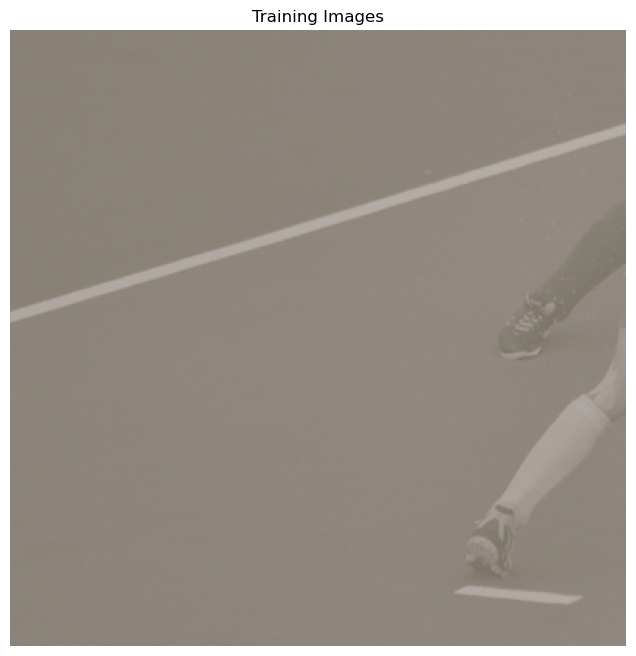

tensor([[[ 0.,  0.,  0.,  0., -1.]]], dtype=torch.float64) tensor(-1., dtype=torch.float64) torch.Size([1, 3, 400, 400])


In [65]:
alb_transform = A.Compose([
    A.augmentations.geometric.transforms.Affine(scale={'x':(0.9, 1.1), 'y':(0.9,1.1)},
                                                translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)},
                                                rotate=(0,360),
                                                mode=cv2.BORDER_REFLECT,
                                                keep_ratio=True),
    A.RandomCrop(width=400, height=400),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', min_area=16,
                            min_visibility=0.3))

transform = torch.jit.script(
                nn.Sequential(
#                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                               # ToTensor(),
                               transforms.ColorJitter(0.2, 0.3, 0.3, 0.01),
                               transforms.RandomApply(transforms=\
                                                   nn.ModuleList([transforms.GaussianBlur(7),]), p=0.3),
                               transforms.RandomApply(transforms=\
                                                   nn.ModuleList([transforms.Grayscale(3)]), p=0.3),
                        ))
dataset = CustomImageDataset(img_dir=images_dir,
                             labels=df,
                             alb_transform=alb_transform,
                             transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)


# Plot some training images
batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
show_batch(batch[0], batch[1])
print(batch[1], batch[1][0][0][4], batch[0].shape)

In [66]:
# plt.imshow(PIL.Image.open('./OpenImages/bdec689b952b3426.jpg').convert('RGB'))

In [67]:
# np.array(df[df.ImageID=='bdec689b952b34260'])[:, [4,5,6,7,13]]
# df[df.ImageID=='bdec689b952b3426']

In [68]:
# model.eval()
# model(batch[0].to(device))

In [69]:
images = []
targets = []

for batch_ind in range(2):
    batch = next(iter(dataloader))
    images_, boxes = batch[0], batch[1][0][0][:4].reshape((1,1,4))
    labels = batch[1][0][0][4].reshape((1,1))
    images.append(images_[0])
    for i in range(1):
        d = {}
        d['boxes'] = boxes[i].float()
        d['labels'] = labels[i].long()
        targets.append(d)
        
targets

[{'boxes': tensor([[  0.0000, 163.1681,  40.7227, 228.1438]]),
  'labels': tensor([0])},
 {'boxes': tensor([[0., 0., 0., 0.]]), 'labels': tensor([-1])}]

In [70]:
model.eval()
output = model(images)
model.train()
output

[{'boxes': tensor([[1.0007e+00, 6.1142e+00, 4.0000e+02, 3.1809e+02],
          [4.8594e+00, 3.1294e+00, 3.9955e+02, 1.9296e+02],
          [4.8594e+00, 3.1294e+00, 3.9955e+02, 1.9296e+02],
          [1.0007e+00, 6.1142e+00, 4.0000e+02, 3.1809e+02],
          [0.0000e+00, 8.7330e+00, 4.0000e+02, 3.1986e+02],
          [1.7197e-02, 8.9831e+01, 3.9843e+02, 3.9260e+02],
          [0.0000e+00, 1.0727e+01, 4.0000e+02, 1.6555e+02],
          [1.0007e+00, 6.1142e+00, 4.0000e+02, 3.1809e+02],
          [0.0000e+00, 1.6044e+01, 4.0000e+02, 3.3549e+02],
          [3.1767e+02, 3.6762e+02, 3.9855e+02, 3.9917e+02],
          [3.2711e-03, 1.6076e+02, 4.1198e+01, 2.3047e+02],
          [5.9475e-01, 1.6997e+02, 1.4070e+02, 3.1508e+02],
          [3.7961e-01, 0.0000e+00, 3.9920e+02, 1.6914e+02],
          [4.8594e+00, 3.1294e+00, 3.9955e+02, 1.9296e+02],
          [0.0000e+00, 2.0283e+02, 4.0000e+02, 3.9066e+02],
          [3.2055e+00, 1.2335e+02, 3.9954e+02, 3.5647e+02],
          [0.0000e+00, 1.2048e+

In [71]:
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead, partial, DefaultBoxGenerator, det_utils
from torchvision.models.detection.fcos import FCOSHead

In [72]:
def set_model_to_training(model, backbone=False, fpn=False, regression_head=True, classification_head=True,
                        freeze_bn=False):
    model.train()
    
    model.head = FCOSHead(model.backbone.out_channels, model.anchor_generator.num_anchors_per_location()[0],
                          num_classes=1)
    
    model.head.requires_grad_(True)
    
    if freeze_bn:
        for layer in model.backbone.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

In [73]:
%cd /kaggle/working

/kaggle/working


In [74]:
set_model_to_training(model, freeze_bn=True)
model.to(device);
model.train();

In [75]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [76]:
for epoch_num in range(100):
    epoch_loss = []
    torch.cuda.empty_cache()
    tq = tqdm(dataloader, total=len(dataloader), leave=False, position=0)
    iter_num = 0
    images = []
    targets = []
    mean_target = []
    for data in tq:
        iter_num+=1
        batch = data
        images_ = batch[0]
        for i in range(len(images_)):
            images.append(images_[i].to(device))
            boxes = batch[1][i][:,:4].reshape((-1,4))
            labels = batch[1][i][:,4].reshape((-1))
            d = {}
            d['boxes'] = boxes.float().to(device)[labels==0]
            d['labels'] = labels.long().to(device)[labels==0]
            targets.append(d)
#                 mean_target.append(d['labels'].item())
#         if(iter_num%batch_size!=0): continue
        
#         print(targets)
        optimizer.zero_grad()
#         print(images[0].shape, len(images), len(targets))
        # print(images, targets)
        
        output = model(images, targets)
#         print(output)
        classification_loss = output['classification']
        regression_loss = output['bbox_regression'] + output['bbox_ctrness'] 

        loss = classification_loss + regression_loss

#         if bool(loss == 0):
#             continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        epoch_loss.append(float(loss.item()))
        tq.set_postfix({"EPOCH":epoch_num,
                        "classification_loss":classification_loss.item(),
                        "regression_loss":regression_loss.item(),
                        "mean_loss":np.mean(epoch_loss)})
        del data
        images.clear()
        targets.clear()
        mean_target.clear()
        gc.collect()
        torch.cuda.empty_cache()

    gc.collect()
    torch.cuda.empty_cache()
        
#     print('Epoch: {} | Iteration: {} | Train classification loss: {:1.5f} | train regression loss: {:1.5f} | Epoch loss: {:1.5f}'\
#           .format(epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))
    scheduler.step(np.mean(epoch_loss)) # should be val loss

Epoch 00035: reducing learning rate of group 0 to 3.0000e-05.


Epoch 00045: reducing learning rate of group 0 to 3.0000e-06.


Epoch 00053: reducing learning rate of group 0 to 3.0000e-07.


Epoch 00057: reducing learning rate of group 0 to 3.0000e-08.


Epoch 00061: reducing learning rate of group 0 to 3.0000e-09.


In [77]:
torch.cuda.empty_cache()
gc.collect()

21

In [78]:
model.eval()
batch = next(iter(dataloader))
output = model(batch[0].to(device))
output

[{'boxes': tensor([[259.7138,  52.7247, 290.2869,  83.0428],
          [  0.0000,  21.8730,  77.5237, 106.1216],
          [  5.3147,  48.1709,  59.4186, 102.3449],
          [ 13.2198,  40.3100,  74.4672, 102.0283],
          [254.5417,  45.7346, 296.1436,  88.5385],
          [  7.9131,  31.7308,  64.2593,  89.5247],
          [  0.0000,  26.3009,  44.2962, 102.5888],
          [ 17.0760,  57.4273,  66.8303, 104.0552],
          [  0.6243,  54.5826,  46.2031,  97.5647],
          [ 20.0291,  27.2111,  70.5640,  79.5683],
          [  3.6177,  23.9055,  55.8657,  76.6006],
          [  9.0803,  63.6826,  52.5536, 101.1784],
          [269.7959,  54.7710, 292.8011,  81.3847],
          [ 27.8364,  37.9220,  75.3371,  90.6691]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'scores': tensor([0.7043, 0.6995, 0.4183, 0.3432, 0.3390, 0.3361, 0.3117, 0.2920, 0.2819,
          0.2797, 0.2498, 0.2242, 0.2163, 0.2140], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'labels': t

[tensor([259.7138,  52.7247, 290.2869,  83.0428])]


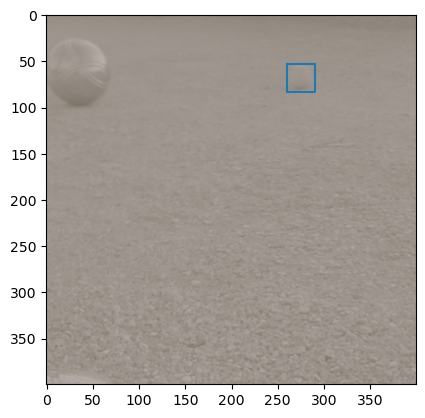

In [79]:
show_batch([img for img in batch[0]], [[boxes['boxes'][0].cpu().data] for boxes in output])

In [80]:
torch.cuda.empty_cache()
gc.collect()

3348

In [81]:
%cd ./dl-course/2023_spring/lecture6

/kaggle/working/dl-course/2023_spring/lecture6


In [82]:
def val_step_model(model, dataloader):
    model.eval()
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=1)
    for iter_num, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        for img, gt in zip(data['img'], data['annot']):
            with torch.no_grad():
                try:
                    bboxes, nms_scores, nms_classes = model([img.to(device)])[0].values()
#                     bboxes[:,0]*=img.shape[1]; bboxes[:,1]*=img.shape[0]
#                     bboxes[:,2]*=img.shape[1]; bboxes[:,3]*=img.shape[0]
                except(RuntimeError):
                    print('no boxes')
                    bboxes, nms_scores, nms_classes = -torch.ones((1,4)), -torch.ones((1)), -torch.ones((1))
            preds = torch.cat([bboxes, nms_classes.unsqueeze(0).T, nms_scores.unsqueeze(0).T], dim = 1).cpu().detach().numpy()
            preds = preds[preds[:,4]==0]
#             print(preds.shape)
            zeros = torch.zeros((gt.shape[0], 1))
            gt = torch.cat([gt, zeros, zeros], 1).cpu().detach().numpy()
            metric_fn.add(preds, gt)
#             print(preds, gt)

        del img, gt, preds, zeros, nms_scores, nms_classes, bboxes
        gc.collect()
        torch.cuda.empty_cache()
    print(f"validation mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")

In [83]:
val_step_model(model ,val_dataloader)

100%|██████████| 57/57 [01:00<00:00,  1.06s/it]


validation mAP in all points: 0.002237865701317787
